# Instalamos los paquetes necesarios

El fin de la siguiente celda es que el usuario cuente con todos los módulos necesarios para la ejecución del programa instalados.

Si el usuario ya tiene los módulos correspondientes instalados, no es necesario la ejecución de la celda.

In [1]:
! python -m pip install --upgrade pip
! pip install --upgrade numpy
! pip install --upgrade scikit-image
! pip install --upgrade opencv-python
! pip install --upgrade matplotlib


# Corrección de aberraciones cromáticas
## Solución basada en el formato HSV, el uso de máscaras y la bajada de saturación

## 1. Integrantes del grupo

Esta práctica ha sido elaborada por el grupo 19 equipo 2, formado por los estudiantes:
* Sergio Álvarez López
* Mario Hernández García
* José Del Castillo Izquierdo
* Nicolás Forero Arévalo
* Álvaro Martín Jiménez

## 2. Descripción del problema

La anomalía de la imagen a corregir es la aberración cromática. 

La aberración cromática es un tipo de aberración óptica, las cuales suelen darse por imperfecciones en la lente. En particular, la aberración cromática se produce cuando la lente no es capaz de hacer converger los distintos colores a un mismo foco.

Las aberraciones cromáticas se caracterizan por una distorsión del color en los contornos de la imagen, produciendo colores con una gran saturación como el verde o el morado.

## 3. Conjunto de imágenes a corregir

Nuestro objetivo principal ha sido la corrección automática y de manera genérica de aberraciones cromáticas. Es por ello que hemos considerado un total de seis imágenes variadas que muestran diferentes tipos de aberraciones cromáticas. Estas imágenes comprenden aberraciones verdes, moradas, amarillas y azules.

Este conjunto de imágenes recoge desde esculturas oxidadas con claras aberraciones cromáticas verdes y moradas en sus contornos, hasta facultades con aberraciones cromáticas amarillas y moradas a lo largo de los bordes de su fachada.

Además, permitimos al usuario evaluar nuestro algoritmo en una imagen de su elección, dándole la facilidad de importar esta imagen en local o mediante una url.

## 4. Solución propuesta

Como hemos comentado anteriormente, nuestro objetivo principal ha sido la detección y corrección de aberraciones cromáticas de una manera automática y general.

Nuestra solución se basa en el modelo de color HSV (Hue, Saturation, Value), del cual aprovecharemos en especial los valores Hue y Saturation tanto para la detección de la aberración mediante máscaras, como para su posterior corrección mediante la bajada de saturación.

Primeramente, calculamos una máscara sobre la imagen con el fin de detectar la aberración. Esta máscara consistirá en una imagen, con las mismas dimensiones que la original, pero completamente en negro a excepción de unos píxeles blancos que señalan dónde se encuentra la aberración. Para encontrar dichos pixeles, primero pasamos la imagen al espacio de color HSV y centrandonos en el componente H (que corresponde al matiz) detectaremos los colores en los que se presenta la aberración y a continuación creamos la mascara con los resultados obtenidos.

El desarrollo de la máscara se ha inspirado en las ideas propuestas en la siguiente página web: https://omes-va.com/deteccion-de-colores/

Una vez hemos detectado dónde se encuentra la aberración, aplicaremos la corrección donde la máscara así lo indique. Esta corrección se basa en bajar por completo la saturación en las zonas indicadas, transformando los colores saturados, como el verde y el morado, en unos tonos grisaceos.

La solución propuesta tiene un caracter general en tanto que la máscara se calcula de manera automática para cada imagen, evitando así la intervención humana para la detección de la aberración.

## 5. Ejecución paso a paso del algoritmo comentada

Primeramente ejecutamos todos los import necesarios. Muestro aquí una lista de todos ellos así como sus principales usos.

* matplotlib - generación de las imágenes a partir de las matrices
* numpy - manejo de las matrices que representan las imágenes
* skimage - manejo de las imágenes, desde su carga hasta el paso de espacio entre colores (RGB, HSV)
* opencv - desarrollo de la máscara
* urllib - importación de imágenes vía url
* os - importación de imágenes desde un fichero local


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data
from skimage import io
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb
import cv2
import urllib
import os

Definimos la función con la que mostraremos resultados en gran tamaño.

In [3]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(11,11))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()


En este momento, el usuario decide a qué imagen le quiere aplicar la corrección.

El usuario selecciona una de las fotos propuestas o una a su elección. En caso de que la foto a corregir no pertenezca al conjunto previamente seleccionado con el que el algoritmo se ha testeado, se ruega que la imagen contenga aberraciones cromáticas basadas en los colores verde, morado, amarillo o azul.

Si se quiere seleccionar una foto fuera del conjunto elegido, se tienen dos opciones:
1. Introducir una nueva imagen en la carpeta fotos y pasar por parámetro en la siguiente celda el nombre del archivo sin su extensión.
2. Introducir la URL donde resida la foto. La foto debe estar en uno de los siguientes formatos: .PNG, .JPG o .JPEG

Finalmente, se muestra en gran tamaño la imagen original sobre la que se aplicara la corrección.

Introduzca el nombre de la imagen que desee ver (peine, arbol, terraza, facultad, tronco o pajaro).
Para introducir una URL pulse la tecla ENTER. 
Se puede añadir una nueva imagen a la carpeta fotos y escribir el nombre del archivo sin su extensión.


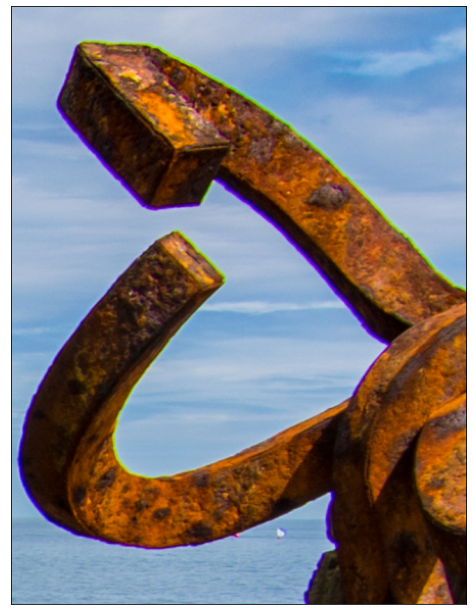

In [4]:
#Para que funcione se deben tener las imágenes descargadas de  github en el almacenamiento interno

print("Introduzca el nombre de la imagen que desee ver (peine, arbol, terraza, facultad, tronco o pajaro).\n"\
      "Para introducir una URL pulse la tecla ENTER. \n"\
      "Se puede añadir una nueva imagen a la carpeta fotos y escribir el nombre del archivo sin su extensión.")



list_images = os.listdir("images")
data_files = {}

for filename in list_images:
    data_files[filename.split(".")[0]] = filename.split(".")[1]

def url_to_image(url):
    # descargamos la imagen, la convertimos en un array NumPy, y leemos la imagen en formato OpenCV (BGR). 
    # Cambiamos la matriz de datos de la imagen a RGB para representarla con la librería plt 
    # sin intercambiar sus canales por defecto.
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

while 1:
    image_name = input("Nombre de la imagen(sin extensión): ")
    if image_name =='':
        print('Introduzca la URL de la foto en formato .PNG, .JPG o .JPEG')
        URL = input()
        image_data= url_to_image(URL)  


    #si nuestro archivo está en la carpeta local
    if image_name !='':

        data_dir = 'images/'

        if image_name in data_files.keys():
            image = os.path.join(data_dir,  image_name + '.' + data_files[image_name])
            image_data = io.imread(image)
            break
        else:
            print("\nNo se encuentra la imagen introducida por la entrada. Vuelva a introducir el nombre de la imagen\n")
            continue

    
imshow(image_data) 
  
    

En este punto crearemos la máscara usando el modelo de color HSV. Es importante saber qué valores puede tomar cada uno de los canales del modelo HSV, los cuales vemos a continuación:
    - H: 0 - 179
    - S: 0 - 255
    - V: 0 - 255
Para crear la máscara seguimos los siguientes pasos:

1. Pasamos la imagen RGB al modelo de color HSV. Para detectar los colores de la aberración nos centraremos en la componente H.
Esta componente pasa de rojo, amarillo, verde, violeta hasta volver nuevamente al rojo, como se puede ver en la siguiente imagen. Esta imagen también se ha obtenido de la página web anteriormente citada: https://omes-va.com/deteccion-de-colores/ 

    <img src="images/hsv.png">

2. La aberración cromática suele presentarse en tonos verdes o morados, basándonos en esto y tomando como referencia la imagen del punto 1 ajustamos los rangos que debemos detectar de verde y de morado, dándonos como resultado los siguientes valores:
    - Rango para la detección de la aberración verde:
        - H: 35 - 90
        - S: 100 - 255
        - V: 100 - 255
    - Rango para la detección de aberración morada:
        - H: 110 - 170
        - S: 100 - 255
        - V: 100 - 255
3. Con la función inRange de opencv obtenemos las máscaras para cada color, para luego sumar ambas imágenes y obtener la máscara que nos permitirá corregir la aberración cromática.

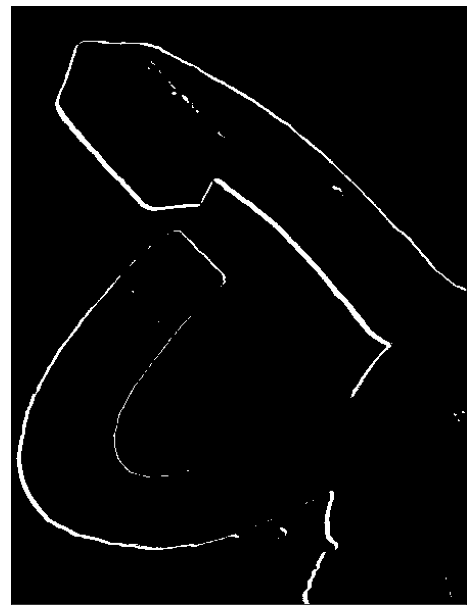

In [5]:
def create_mask(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    green_low = np.array([35, 100, 100])
    green_high = np.array([90, 255, 255])
    blue_low = np.array([110, 100, 100])
    blue_high = np.array([170, 255, 255])

    mask1 = cv2.inRange(hsv, green_low, green_high)
    mask2 = cv2.inRange(hsv, blue_low, blue_high)
    mask = cv2.add(mask1, mask2)
    return mask

imshow(create_mask(image_data))


Finalmente, una vez se ha detectado la máscara, se procede a su corrección.

Como ya se ha comentado, la corrección se realiza mediante dos bucles anidados en los que se va recorriendo la máscara con el fin de detectar los píxeles blancos, i.e. cuando el valor de la máscara es 255.

Una vez que se encuentra un píxel blanco, se accede a la misma posición pero en la capa correspondiente a la saturación de la imagen por corregir y se baja su valor a cero (recordemos que esto es posible porque estamos trabajando en el espacio HSV y porque las dimensiones de la máscara coinciden con las dimensiones de las capas de la imagen original).

Finalmente, se muestra la imagen corregida, en la que se puede observar cómo los tonos saturados de la aberración cromática han sido reemplazados por tonos grisaceos.

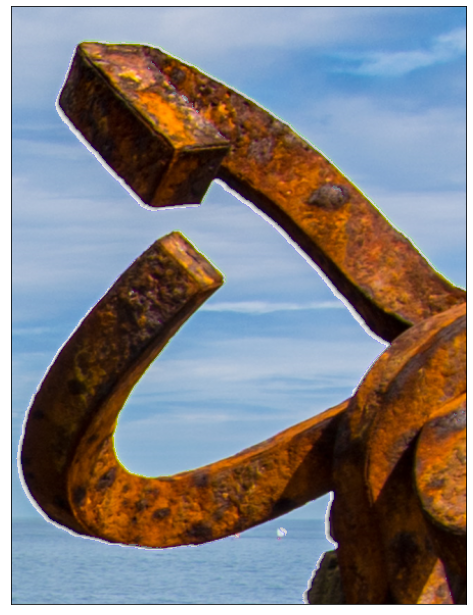

In [6]:
def fix_ab_cromatica(rgb_img):

    hsv_img = rgb2hsv(rgb_img)
    layer_shape = hsv_img[:,:,1].shape
    x_shape = layer_shape[0]
    y_shape = layer_shape[1]
    mascara = create_mask(rgb_img)
    for i in range(x_shape):
        for j in range(y_shape):
            if mascara[i][j] == 255:
                hsv_img[:,:,1][i][j] = 0
    rgb_img_fixed = hsv2rgb(hsv_img)
    return rgb_img_fixed

fixed_image = fix_ab_cromatica(image_data)
imshow(fixed_image)

Terminamos la ejecución del programa mostrando una comparativa entre la imagen original y la imagen corregida, adjuntando también la correspondiente máscara.

Text(0.5, 1.0, 'Imagen corregida')

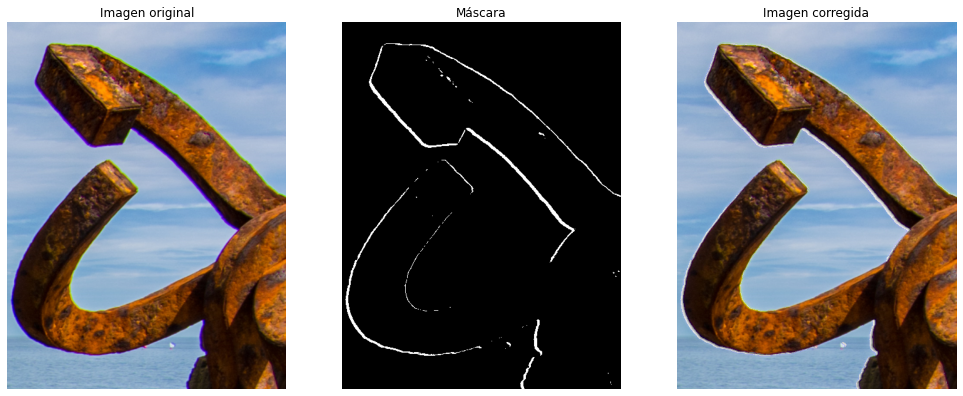

In [7]:
#hacemos una comparativa de los pasos hechos y el resultado obtenido
plt.figure(figsize=(17,12))

plt.subplot (131)
plt.axis('off')
plt.title('Imagen original')
plt.imshow(image_data)

plt.subplot (132)
plt.axis('off')
plt.title('Máscara')
plt.imshow(create_mask(image_data), cmap=plt.cm.gray)

plt.subplot (133)
plt.imshow(fixed_image)
plt.axis('off')
plt.title('Imagen corregida')



Finalizamos el notebook mostrando el conjunto de imágenes seleccionadas, las cuales se encuentran en el directorio "images", las máscaras producidas por el programa, y la imagen corregida.

In [ ]:
data_files = os.listdir("images")
list_images= [ os.path.join("images", file) for file in data_files]

for image in list_images:

    if image[-7:] == "hsv.png":
        continue

    photo_data = io.imread(image)
    #hacemos una comparativa de los pasos hechos y el resultado obtenido por cada uno de los archivos
    plt.figure(figsize=(17,12))

    plt.subplot (131)
    plt.axis('off')
    plt.title('Imagen original')
    plt.imshow(photo_data)

    plt.subplot (132)
    plt.axis('off')
    plt.title('Máscara')
    plt.imshow(create_mask(photo_data), cmap=plt.cm.gray)

    plt.subplot (133)
    plt.imshow(fix_ab_cromatica(photo_data))
    plt.axis('off')
    plt.title('Imagen corregida')


## 6. Conclusión

Todo el equipo ha terminado muy satisfecho con los resultados obtenidos. En particular, nos sentimos especialmente orgullosos de haber conseguido un cálculo automático de la máscara, ya que este era uno de los principales retos al que nos enfrentamos cuando diseñamos cómo abordar el problema. También hemos terminado especialmente contentos por el efecto de la corrección, el cual trata particularmente bien los colores con tonos morados y verdosos, como se puede ver en la corrección de la imagen de "El peine del viento".

Muchas gracias por su atención.